## Causal Forest

In [3]:
import random
import pandas as pd
import numpy as np
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
# from SyncRNG import SyncRNG
import numpy as np
import re
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy import linalg
from itertools import chain

from CTL.causal_tree_learn import CausalTree
from sklearn.model_selection import train_test_split
import plotnine as p
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Alvaro\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Alvaro\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [55]:
import scipy.stats as st
import statsmodels.stats.api as sms

In [4]:
import econml
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest

### Data

In [5]:
data_all = pd.read_csv("synthetic_data.csv" )

n = data_all.shape[0]

In [6]:
data_all

,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1,0,0.423366,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10387,1,0,-0.197092,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10388,1,0,0.141698,2,15,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10389,1,0,-0.351565,5,4,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702


In [7]:
# Drop school id
DF = data_all.drop(labels= "schoolid", axis = 1)
DF

,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0,0.423366,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10387,0,-0.197092,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10388,0,0.141698,2,15,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10389,0,-0.351565,5,4,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702


In [8]:
# Matrices

school_id = data_all["schoolid"]

school_mat = pd.get_dummies(school_id)

school_size = np.sum(school_mat)

### 1. How the tree was built?



In [9]:
# first regression

#Not necesary
#w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
#summary(w.lm)

W =None

#Treatmnent variable 
T = DF["Z"]

#Outcome variable
Y = DF["Y"]
 
# 10 covariates
X_raw = DF.iloc[:, 2:12]


school_mat = pd.get_dummies(school_id) #PY

C1_exp = pd.get_dummies(X_raw["C1"])
XC_exp = pd.get_dummies(X_raw["XC"])

In [10]:
# X Covariates DF
  
X1 = X_raw.merge(C1_exp, left_index=True, right_index=True)
X = X1.merge(XC_exp, left_index=True, right_index=True)
X = X.drop(labels= ["C1","XC"], axis = 1)
X

,S3,C2,C3,X1,X2,X3,X4,X5,1_x,2_x,...,11,12,13,14,15,0,1_y,2_y,3_y,4_y
0,6,2,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4,2,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,1,0,0,0,0,0,0,0,1
2,6,2,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6,2,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
4,6,1,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,7,2,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,0,0,0,0,1,0
10387,7,2,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,0,0,0,0,1,0
10388,2,1,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,1,0,0,0,1,0
10389,5,1,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
def cluster_causal_forest(Y,T, X, W,  cluster):        
        
        base = pd.concat([Y,T], axis = 1)
        
        for i in range(cluster):
        
            index=range(X.shape[0]) 
            a = np.array_split(np.array(index),cluster)[i]  ## split index
            
            Y = base.drop(base.iloc[list(a),:].index).iloc[:,0]
            T = base.drop(base.iloc[list(a),:].index).iloc[:,1]
            XX = X.drop(X.iloc[list(a),:].index)
            causal = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)
            causal.fit(Y, T, X=XX, W=W)
            
            tau_hat = causal.effect(X=X.iloc[list(a),:]) # tau(X) estimates using validation test
            vector = i*np.ones( len(list(a)) )
            globals()[f'data_{i}'] = pd.DataFrame({"tau_hat":tau_hat, "Cluster":vector})
                                                    
        
       
        tau_predict = data_0.copy()

        for k in range(1,10):
            tau_predict = tau_predict.append(globals()[f'data_{k}'] , ignore_index=True)
            
        
        
        return tau_predict

In [46]:
# Prepare dataset
fmla = 'S3+C2+C3+X1+X2+X3+X4+X5'
desc = patsy.ModelDesc.from_formula(fmla)
matrix = patsy.dmatrix(fmla, data_all, return_type = "dataframe")


# Number of rankings that the predictions will be ranking on 
# (e.g., 2 for above/below median estimated CATE, 5 for estimated CATE quintiles, etc.)
num_rankings = 5  

# Prepare for data.splitting
# Assign a fold number to each observation.
# The argument 'clusters' in the next step will mimick K-fold cross-fitting.
num_folds = 10

# Estimate a causal forest.

cluster_causal_forest(Y,T, X, W,  cluster = num_folds)


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


### 2. Estimate ATE

In [52]:
clu_ct = cluster_causal_forest(Y,T, X, W,  cluster = num_folds)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [88]:

#print("95% CI of ATE cluster_CT is: ", s95ct)

Text(0.5, 1.0, 'CATE estimates')

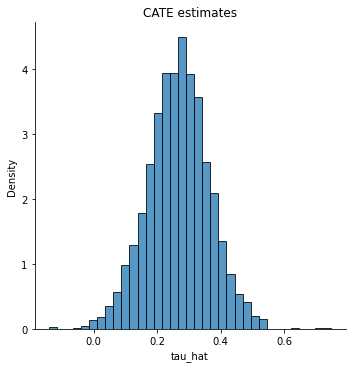

In [92]:
# Do not use this for assessing heterogeneity. See text above.
sns.displot( clu_ct["tau_hat"], stat="density", bins = 35)
plt.title("CATE estimates")

### 3. Run best linear predictor analysis

In [29]:
high_effect = tau.hat > median(tau.hat)
ate_high = average_treatment_effect(cf, subset = high_effect)
ate_low = average_treatment_effect(cf, subset = !high_effect)

SyntaxError: invalid syntax (Temp/ipykernel_21548/256934608.py, line 3)

### 4. Look at school-wise heterogeneity

### Analysis ignoring clusters. How do the results change?

In [31]:
# Grow a forest. Add extra trees for the causal forest.



# Estimate a causal forest.
est2 = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

est2.tune(Y, T, X=X, W=W)
est2.fit(Y, T, X=X, W=W)


In [ ]:
sns.displot( tau_hat, stat="density", bins = 10)
plt.title("CATE estimates")

### 6. Analysis without fitting the propensity score

### 7. PLOTS

### 8. Visualize school-level covariates by treatment heterogeneit

In [ ]:
df = pd.DataFrame()
for var_name in covariates:
    form2 = var_name + " ~ " + "0" + "+" + "leaf"
    ols = smf.ols(formula=form2, data=data1).fit(cov_type = 'HC2').summary2().tables[1].iloc[:, 0:2]
    
    
    # Retrieve results
    toget_index = ols["Coef."]
    index = toget_index.index
    cova1 = pd.Series(np.repeat(var_name,num_leaves), index = index, name = "covariate")
    avg = pd.Series(ols["Coef."], name="avg")
    stderr = pd.Series(ols["Std.Err."], name = "stderr")
    ranking = pd.Series(np.arange(1,num_leaves+1), index = index, name = "ranking")
    scaling = pd.Series(norm.cdf((avg - np.mean(avg))/np.std(avg)), index = index, name = "scaling")
    data2 = pd.DataFrame(data=x_test, columns= covariates)
    variation1= np.std(avg) / np.std(data2[var_name])
    variation = pd.Series(np.repeat(variation1, num_leaves), index = index, name = "variation")
    labels = pd.Series(round(avg,2).astype('str') + "\n" + "(" + round(stderr, 2).astype('str') + ")", index = index, name = "labels")
    
    # Tally up results
    df1 = pd.DataFrame(data = [cova1, avg, stderr, ranking, scaling, variation, labels]).T
    df = df.append(df1)

# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df = df.sort_values(by = ["variation", "covariate"], ascending = False)

df = df.iloc[0:(8*num_leaves), :]
df1 = df.pivot(index = "covariate", columns = "ranking", values = ["scaling"]).astype(float)
labels =  df.pivot(index = "covariate", columns = "ranking", values = ["labels"]).to_numpy()

# plot heatmap
ax = plt.subplots(figsize=(18, 10))
ax = sns.heatmap(df1, 
                 annot=labels,
                 annot_kws={"size": 12, 'color':"k"},
                 fmt = '',
                 cmap = "terrain_r",
                 linewidths=0,
                 xticklabels = ranking)
plt.tick_params( axis='y', labelsize=15, length=0, labelrotation=0)
plt.tick_params( axis='x', labelsize=15, length=0, labelrotation=0)
plt.xlabel("Leaf (ordered by prediction, low to high)", fontsize= 15)
plt.ylabel("")
ax.set_title("Average covariate values within leaf", fontsize=18, fontweight = "bold")

### 9. CATE by school